In [1]:
import sqlite3

import numpy as np
import pandas as pd
from nltk import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
from multiprocessing import Pool
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
import gensim
import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
from keras import Sequential
from keras.layers import Activation, Dense, Dropout
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
np.set_printoptions(precision=2, linewidth=80)
from nltk.tokenize.toktok import ToktokTokenizer
import spacy
nlp = spacy.load('en', parse=False, tag=False, entity=False)


Using TensorFlow backend.


In [2]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
con1 = sqlite3.connect('amazon_cellreviews.db')
#check database
sql = " SELECT * FROM reviews"
dfdb = pd.read_sql_query(sql, con1)
con1.close()

In [3]:
print('Total Rows: ' + str(len(dfdb)))
print('Sample of processed dataset. Notice the column named Clean_Review');
dfdb.head(20)


Total Rows: 1030176
Sample of processed dataset. Notice the column named Clean_Review


,index,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,Clean_Review,vote,sentiment,Review_Time,Month,Year
0,0,5.0,1,A24E3SXTC62LJI,7508492919,Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,look even well person careful drop phone often...,None,1,2014-08-04 00:00:00,8,2014
1,1,5.0,1,A269FLZCB4GIPV,7508492919,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,want spend whole lot cash want great deal shop...,None,1,2014-02-12 00:00:00,2,2014
2,7,5.0,1,A31OVFL91BCKXG,7508492919,Ashley Nicole Miller,It is a very cute case. None of the jewels hav...,Cute case,1389916800,it cute case none jewel fall bow glue well com...,None,1,2014-01-17 00:00:00,1,2014
3,11,5.0,1,A2ZB7KGUSBR9P3,7508492919,E. Bryce,Another great product that my daughter she use...,Bling bling for iPhone 4S,1382486400,another great product daughter use long time i...,None,1,2013-10-23 00:00:00,10,2013
4,14,5.0,1,A18U23JWTMQX5C,7508492919,KaitlynxO625,Beautiful quality and outstanding product! Eve...,I can't stop using this case!,1378771200,beautiful quality outstanding product everyone...,None,1,2013-09-10 00:00:00,9,2013
5,15,5.0,1,A1JQUCTFM4UKMQ,7508492919,M. Antillon,It is such a good case for a low price. I have...,I love it,1377648000,it good case low price i right never problem b...,None,1,2013-08-28 00:00:00,8,2013
6,18,5.0,1,A29KSIE8BKYVQN,7508492919,Janine B.,Super durable and I get compliments on it dail...,Good case,1370304000,super durable i get compliment daily i find on...,None,1,2013-06-04 00:00:00,6,2013
7,19,5.0,1,A2CQO0FORCTC2R,7508492919,Sulli,I have used this case for a couple weeks & so ...,very sparkly,1370217600,i use case couple week far great little bling ...,None,1,2013-06-03 00:00:00,6,2013
8,21,5.0,1,A2ROMLP8COJ6JA,7508492919,Mary Beth Anderson,I chose this case because it is so beautiful. ...,Beautiful,1367625600,i choose case beautiful everyone like ask coul...,None,1,2013-05-04 00:00:00,5,2013
9,22,5.0,1,A23MRCVKI8M8OY,7508492919,T...,Of all my cases this is the one that I have on...,pink bow,1366761600,case one i phone right i love love love fit gr...,None,1,2013-04-24 00:00:00,4,2013


# ============================================
# Prune for local development
# ============================================

In [4]:
trial=2000

#subset for local runs, will remove on final runs or on server
five=(dfdb['overall'] == 5.0)
four=(dfdb['overall'] >= 4.0) & (dfdb['overall'] < 5.0)
three=(dfdb['overall'] == 3.0) & (dfdb['overall'] < 4.0)
two=(dfdb['overall'] == 2.0) & (dfdb['overall'] < 3.0)
one=(dfdb['overall'] == 1.0) & (dfdb['overall'] < 2.0)
zero=(dfdb['overall'] == 0.0) & (dfdb['overall'] < 1.0)

df=pd.DataFrame(columns = dfdb.columns)
if(trial>0):
    df=dfdb[five].iloc[0:trial]
    df=df.append(dfdb[four].iloc[0:trial])
    df=df.append(dfdb[two].iloc[0:trial])
    df=df.append(dfdb[one].iloc[0:trial])
    df=df.append(dfdb[zero].iloc[0:trial])
else:
    df=dfdb[five]
    df=df.append(dfdb[four])
    df=df.append(dfdb[two])
    df=df.append(dfdb[one])
    df=df.append(dfdb[zero])
    
print('Total Rows: ' + str(len(df)))
# Sample of Unprocessed reviews pruned for local development
df.head(10)

#randomize dataset
from sklearn.utils import shuffle
df = shuffle(df)

Total Rows: 8000


In [5]:
# take a peek at the data
reviews = np.array(df['Clean_Review'])
sentiments = np.array(df['sentiment'])

cutoff=round(len(df)*0.75)
# build train and test datasets
train_reviews = reviews[:cutoff]
train_sentiments = sentiments[:cutoff]
test_reviews = reviews[cutoff:]
test_sentiments = sentiments[cutoff:]

# Traditional Supervised Machine Learning Models

## Feature Engineering

In [6]:

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_reviews)
# build ngram features on train reviews
cvn = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(2,2))
cvn_train_features = cvn.fit_transform(train_reviews)
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)

In [7]:
# transform test reviews into features
cv_test_features = cv.transform(test_reviews)
cvn_test_features = cvn.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)


## Model Training, Prediction and Performance Evaluation

In [8]:
svm = SGDClassifier(loss='hinge', max_iter=100)


In [9]:
svm_bow_predictions = meu.train_predict_model(classifier=svm, train_features=cv_train_features, 
                                              train_labels=train_sentiments,test_features=cv_test_features, 
                                              test_labels=test_sentiments)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,classes=[1, 0])

BOW model:> Train features shape: (6000, 159374)  Test features shape: (2000, 159374)
Model Performance metrics:
------------------------------
Accuracy: 0.841
Precision: 0.841
Recall: 0.841
F1 Score: 0.841

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.84      0.84      0.84      1012
           0       0.84      0.84      0.84       988

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   1    0
Actual: 1        854  158
        0        160  828


C:\Users\rkaushik\PycharmProjects\senti_amazon\model_evaluation_utils.py:60: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\Users\rkaushik\PycharmProjects\senti_amazon\model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [10]:
svm_ngram_predictions = meu.train_predict_model(classifier=svm, train_features=cvn_train_features, train_labels=train_sentiments,test_features=cvn_test_features, test_labels=test_sentiments)
print('NGRAM model:> Train features shape:', cvn_train_features.shape, ' Test features shape:', cvn_test_features.shape)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_ngram_predictions,classes=[1, 0])



NGRAM model:> Train features shape: (6000, 148159)  Test features shape: (2000, 148159)
Model Performance metrics:
------------------------------
Accuracy: 0.7775
Precision: 0.7822
Recall: 0.7775
F1 Score: 0.7763

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.75      0.85      0.79      1012
           0       0.82      0.71      0.76       988

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   1    0
Actual: 1        856  156
        0        289  699


In [11]:
svm_tfidf_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=tv_train_features, train_labels=train_sentiments,
                                                test_features=tv_test_features, test_labels=test_sentiments)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,classes=[1, 0])


TFIDF model:> Train features shape: (6000, 159374)  Test features shape: (2000, 159374)
Model Performance metrics:
------------------------------
Accuracy: 0.86
Precision: 0.8604
Recall: 0.86
F1 Score: 0.8599

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.85      0.88      0.86      1012
           0       0.87      0.84      0.86       988

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   1    0
Actual: 1        889  123
        0        157  831


In [12]:
#move to after last plot

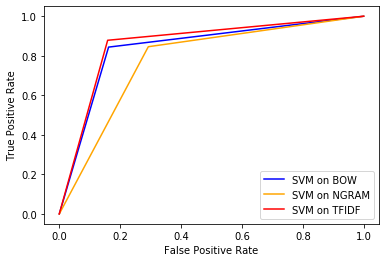

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import metrics

plt.figure(0).clf()

color = ['blue', 'orange', 'red', 'green', 'coral',
             'grey', 'indigo', 'gold', 'lime', 'olive',
             'pink', 'navy', 'magenta', 'yellow', 'tomato',
             'turquoise', 'yellowgreen', 'maroon', 'lightblue']

fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, svm_bow_predictions)
auc = metrics.roc_auc_score(test_sentiments, svm_bow_predictions)
plt.plot(fpr, tpr,color=color[0], label='SVM on BOW')

fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, svm_ngram_predictions)
auc = metrics.roc_auc_score(test_sentiments, svm_ngram_predictions)
# plot the roc curve for the model
plt.plot(fpr, tpr,color=color[1], label='SVM on NGRAM')

fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, svm_tfidf_predictions)
auc = metrics.roc_auc_score(test_sentiments, svm_tfidf_predictions)
# plot the roc curve for the model
plt.plot(fpr, tpr,color=color[2], label='SVM on TFIDF')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

plt.show()


In [14]:
from sklearn.metrics import classification_report

classification_report(test_sentiments,svm_bow_predictions)





'              precision    recall  f1-score   support\n\n           0       0.84      0.84      0.84       988\n           1       0.84      0.84      0.84      1012\n\n    accuracy                           0.84      2000\n   macro avg       0.84      0.84      0.84      2000\nweighted avg       0.84      0.84      0.84      2000\n'

## Feature Engineering with word embeddings

In [ ]:
tn = ToktokTokenizer()
tokenized_train = [tn.tokenize(text)
                   for text in train_reviews]
tokenized_test = [tn.tokenize(text)
                   for text in test_reviews]

# build word2vec model
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3)    

In [ ]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=500)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=500)


In [ ]:
svm_wv_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=avg_wv_train_features, train_labels=train_sentiments,
                                                test_features=avg_wv_test_features, test_labels=test_sentiments)
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_wv_predictions,classes=[1, 0])


In [ ]:
# feature engineering with GloVe model
train_nlp = [nlp(item) for item in train_reviews]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [nlp(item) for item in test_reviews]
test_glove_features = np.array([item.vector for item in test_nlp])

In [ ]:
print('GloVe model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)

svm_glove_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=train_glove_features, train_labels=train_sentiments,
                                                test_features=test_glove_features, test_labels=test_sentiments)
print('Glove model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_glove_predictions,classes=[1, 0])

